In [3]:
# Load python packages
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats as stats
import scipy.sparse as sparse
import statsmodels.api as sm

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [3]:
%%R
# Load R packages
library(edgeR)
library(DESeq2)
library(limma)
library(glmGamPoi)
library(glmmTMB)
library(nebula)
library(fixest)
library(MAST)
library(SingleCellExperiment)
library(scuttle)
library(lme4)

## Load data

In [4]:
# Load data
adata = sc.read_h5ad('data/Yazar/yazar.h5ad')
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,donor_id,pool_number,predicted.celltype.l2,predicted.celltype.l2.score,age,organism_ontology_term_id,...,is_primary_data,suspension_type,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage
barcode,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGAATGTTG-1,onek1k,4921.0,1256,1.341191,691_692,1,CD4 TCM,0.605378,66,NCBITaxon:9606,...,True,cell,"central memory CD4-positive, alpha-beta T cell",10x 3' v2,normal,Homo sapiens,male,blood,European,66-year-old human stage
AAACCTGAGAGAACAG-1,onek1k,2523.0,941,3.606817,693_694,1,NK,1.000000,88,NCBITaxon:9606,...,True,cell,natural killer cell,10x 3' v2,normal,Homo sapiens,female,blood,European,88-year-old human stage
AAACCTGAGCATGGCA-1,onek1k,2565.0,716,3.274854,688_689,1,CD4 Naive,0.557355,66,NCBITaxon:9606,...,True,cell,"naive thymus-derived CD4-positive, alpha-beta ...",10x 3' v2,normal,Homo sapiens,male,blood,European,66-year-old human stage
AAACCTGAGTATTGGA-1,onek1k,8992.0,1859,2.524466,683_684,1,CD8 TEM,0.359614,78,NCBITaxon:9606,...,True,cell,"effector memory CD8-positive, alpha-beta T cell",10x 3' v2,normal,Homo sapiens,male,blood,European,78-year-old human stage
AAACCTGAGTGTCCCG-1,onek1k,3591.0,992,4.678363,684_685,1,CD8 TEM,0.896674,75,NCBITaxon:9606,...,True,cell,"effector memory CD8-positive, alpha-beta T cell",10x 3' v2,normal,Homo sapiens,female,blood,European,75-year-old human stage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCCGCTGTT-9,onek1k,4321.0,1073,3.031706,796_797,9,B intermediate,0.811524,64,NCBITaxon:9606,...,True,cell,transitional stage B cell,10x 3' v2,normal,Homo sapiens,male,blood,European,64-year-old human stage
TTTGTCATCCGTTGTC-9,onek1k,4890.0,1013,2.106339,800_801,9,CD4 TCM,0.922046,37,NCBITaxon:9606,...,True,cell,"central memory CD4-positive, alpha-beta T cell",10x 3' v2,normal,Homo sapiens,female,blood,European,37-year-old human stage
TTTGTCATCGCCGTGA-9,onek1k,4636.0,919,2.243313,821_822,9,CD4 Naive,0.763648,90,NCBITaxon:9606,...,True,cell,"naive thymus-derived CD4-positive, alpha-beta ...",10x 3' v2,normal,Homo sapiens,male,blood,European,90-year-old human stage


In [5]:
adata.obs['cell_type'].value_counts()

central memory CD4-positive, alpha-beta T cell           289000
naive thymus-derived CD4-positive, alpha-beta T cell     259012
natural killer cell                                      164933
effector memory CD8-positive, alpha-beta T cell          161051
naive B cell                                              65702
naive thymus-derived CD8-positive, alpha-beta T cell      52538
CD14-positive monocyte                                    36130
effector memory CD4-positive, alpha-beta T cell           31261
memory B cell                                             30234
transitional stage B cell                                 29889
regulatory T cell                                         26531
gamma-delta T cell                                        18922
CD4-positive, alpha-beta cytotoxic T cell                 17993
central memory CD8-positive, alpha-beta T cell            16409
CD14-low, CD16-positive monocyte                          15743
mucosal invariant T cell                

## Subsample to 5000 cells (randomly)

In [6]:
np.random.seed(0)
cell_idx_random = np.random.binomial(
    n=1,
    p=5000/adata.shape[0],
    size=adata.shape[0]
).astype(bool)
adata_sub = adata[cell_idx_random,:].copy()

## Benchmark preprocessing

1. Select cell-type.
2. Assign random treatment label.
3. Select transcripts with > 10 counts.
4. Output count matrix $\texttt{Y}$, design matrix $\texttt{X}$, size fator $\texttt{sf}$ and membership label.

In [7]:
# label definition: column name in adata.obs
var_celltype = 'cell_type'
var_subject = 'donor_id'
var_treat_random = 'random_treat'

# assign random treatment label

adata_sub.obs.loc[:, var_treat_random] = np.random.binomial(
    n=1, 
    p=0.5, 
    size=adata_sub.shape[0]
)

# select transcripts with >10 counts
gene_idx_threshold = np.asarray(np.sum(adata_sub.X, axis=0) > 10).ravel()

# Produce Y, X, sf
matrix_count = adata_sub.X[:, gene_idx_threshold].tocsc()
matrix_design = sm.add_constant(
    pd.get_dummies(
        adata_sub.obs[var_treat_random], 
        drop_first=True
    )
).values
cell_sizefactor = np.asarray(np.sum(adata_sub.X, axis=1)).ravel()
cell_sizefactor = cell_sizefactor / cell_sizefactor.mean()
cell_subject = pd.factorize(adata_sub.obs[var_subject])[0]

## Pseudobulk generation

1. Aggregate(=sum) cell counts according to treatment & subject label

In [8]:
# convert psueobulk label to integer
cell_label_pseudobulk, subject_label = pd.factorize(
    adata_sub.obs[var_subject].astype(str) + 
    '-' + 
    adata_sub.obs[var_treat_random].astype(str)
)

# generate summation matrix
spmatrix_subject_sum = sparse.csc_matrix(
    (
        np.ones(adata_sub.shape[0]),
        cell_label_pseudobulk,
        np.arange(adata_sub.shape[0]+1)
    ),
    shape = (
        subject_label.shape[0], 
        adata_sub.shape[0]
    )
)

# generate pseudobulk count, design matrix
matrix_pb_count = spmatrix_subject_sum.dot(
    adata_sub.X
)[:, gene_idx_threshold].T
matrix_pb_design = sm.add_constant(
    pd.get_dummies(
        [x.split('-')[1] for x in subject_label], 
        drop_first=True
    )
).values


## Poisson regression (MLE)

In [10]:
%%time
gene_beta_pr = np.zeros(matrix_count.shape[1])
gene_bse_pr = np.zeros(matrix_count.shape[1])
gene_p_pr = np.zeros(matrix_count.shape[1])

for gene_idx_int in range(matrix_count.shape[1]):
    mod = sm.GLM(
        endog=matrix_count[:,gene_idx_int].toarray().ravel(), 
        exog=matrix_design, 
        family=sm.families.Poisson(), 
        offset=np.log(cell_sizefactor)
    )
    fit = mod.fit(tol=1e-10)
    gene_beta_pr[gene_idx_int] = fit.params[1]
    gene_bse_pr[gene_idx_int] = fit.bse[1]
    gene_p_pr[gene_idx_int] = fit.pvalues[1]

CPU times: user 2h 5min 28s, sys: 2h 24min 36s, total: 4h 30min 5s
Wall time: 5min 38s


## Poisson regression (robust)

In [11]:
%%time
gene_beta_rpr = np.zeros(matrix_count.shape[1])
gene_bse_rpr = np.zeros(matrix_count.shape[1])
gene_p_rpr = np.zeros(matrix_count.shape[1])

for gene_idx_int in range(matrix_count.shape[1]):
    mod = sm.GLM(
        endog=matrix_count[:,gene_idx_int].toarray().ravel(), 
        exog=matrix_design, 
        family=sm.families.Poisson(), 
        offset=np.log(cell_sizefactor)
    )
    fit = mod.fit(cov_type='HC0', tol=1e-10)
    gene_beta_rpr[gene_idx_int] = fit.params[1]
    gene_bse_rpr[gene_idx_int] = fit.bse[1]
    gene_p_rpr[gene_idx_int] = fit.pvalues[1]

CPU times: user 2h 23min 52s, sys: 2h 47min 1s, total: 5h 10min 53s
Wall time: 6min 29s
Parser   : 166 ms


## Negative-binomial regression (statsmodels)

In [12]:
%%time
gene_beta_nb = np.zeros(matrix_count.shape[1])
gene_bse_nb = np.zeros(matrix_count.shape[1])
gene_p_nb = np.zeros(matrix_count.shape[1])

for gene_idx_int in range(matrix_count.shape[1]):
    mod = sm.GLM(
        endog=matrix_count[:,gene_idx_int].toarray().ravel(), 
        exog=matrix_design, 
        family=sm.families.NegativeBinomial(), 
        offset=np.log(cell_sizefactor)
    )
    fit = mod.fit(tol=1e-10)
    gene_beta_nb[gene_idx_int] = fit.params[1]
    gene_bse_nb[gene_idx_int] = fit.bse[1]
    gene_p_nb[gene_idx_int] = fit.pvalues[1]

CPU times: user 1h 57min 36s, sys: 2h 15min 1s, total: 4h 12min 38s
Wall time: 5min 16s


## Negative-binomial regression (glmGamPoi, robust)

In [13]:
gene_beta_ggp = np.zeros(matrix_count.shape[1])
gene_bse_ggp = np.zeros(matrix_count.shape[1])
gene_p_ggp = np.zeros(matrix_count.shape[1])
matrix_count_T = matrix_count.T.tocsc()

In [14]:
%%time
%%R -i matrix_count_T -i matrix_design -i cell_sizefactor -o gene_beta_ggp -o gene_p_ggp

matrix_count_T <- as(matrix_count_T, "dgCMatrix")
fit <- glmGamPoi::glm_gp(
    matrix_count_T, 
    matrix_design, 
    on_disk=FALSE, 
    size_factors=as.numeric(cell_sizefactor)
    )
test <- glmGamPoi::test_de(fit, contrast=`Coef_2`)

gene_beta_ggp <- summary(fit)$Beta[,2]
gene_p_ggp <- test$pval

CPU times: user 7min 28s, sys: 27.6 s, total: 7min 56s
Wall time: 2min 57s


## Pseudobulk (edgeR)

In [15]:
%%time
%%R -i matrix_pb_count -i matrix_pb_design -i subject_label -o gene_p_edger -o gene_beta_edger
y <- edgeR::DGEList(matrix_pb_count, group=subject_label)
y <- edgeR::calcNormFactors(y)
y <- edgeR::estimateDisp(y, matrix_pb_design)
fit <- edgeR::glmQLFit(y, matrix_pb_design)
qlf <- edgeR::glmQLFTest(fit, coef=2)

gene_p_edger <- qlf$table[,'PValue']
gene_beta_edger <- qlf$table[,'logFC']

CPU times: user 9min 43s, sys: 18.5 s, total: 10min 2s
Wall time: 5min 32s


## Pseudobulk (DESeq2)

In [16]:
%%time
%%R -i matrix_pb_count -i matrix_pb_design -i subject_label -o gene_p_deseq2 -o gene_beta_deseq2
dds <- DESeq2::DESeqDataSetFromMatrix(
    matrix_pb_count,
    colData = matrix_pb_design,
    design = ~ 1+V2
)
dds <- DESeq2::estimateSizeFactors(dds)
dds <- DESeq2::estimateDispersions(dds, quiet = TRUE)
dds <- DESeq2::nbinomWaldTest(dds)
        
gene_beta_deseq2 <- results(dds)[,'log2FoldChange']
gene_p_deseq2 <- results(dds)[,'pvalue']

CPU times: user 9min 26s, sys: 39.5 s, total: 10min 5s
Wall time: 8min 20s


## Poisson mixed model (glmmTMB)

In [ ]:
%%time
%%R -i matrix_count -i matrix_design -i cell_sizefactor -i cell_subject -o gene_beta_pmm -o gene_p_pmm

data <- matrix_count@x
row_indices <- matrix_count@i # i,p both 0-base like base R
indptr <- matrix_count@p

gene_beta_pmm <- rep(0, ncol(matrix_count))
gene_p_pmm <- rep(1, ncol(matrix_count))

for (gene_idx_int in 1:ncol(matrix_count)){
    # select gene from count matrix: manual indexing for speed
    y <- rep(0, nrow(matrix_count))
    y[row_indices[(indptr[gene_idx_int]+1):indptr[gene_idx_int+1]]+1] <- data[(indptr[gene_idx_int]+1):indptr[gene_idx_int+1]]
    
    # design matrix for fixest
    df_matrix_design <- as.data.frame(matrix_design)
    df <- cbind(y, cell_subject, df_matrix_design)
    
    # glmer fit
    fit <- glmmTMB::glmmTMB(y ~ V2 + (1|cell_subject), data=df, offset=log(cell_sizefactor), family=poisson)
    
    
    gene_beta_pmm[gene_idx_int] <- summary(fit)$coefficients$cond[2,1]
    gene_p_pmm[gene_idx_int] <- summary(fit)$coefficients$cond[2,4]   
}

## NB mixed model (glmmTMB)

In [ ]:
%%time
%%R -i matrix_count -i matrix_design -i cell_sizefactor -i cell_subject -o gene_beta_nbmm -o gene_p_nbmm

data <- matrix_count@x
row_indices <- matrix_count@i # i,p both 0-base like base R
indptr <- matrix_count@p

gene_beta_nbmm <- rep(0, ncol(matrix_count))
gene_p_nbmm <- rep(1, ncol(matrix_count))

for (gene_idx_int in 1:ncol(matrix_count)){
    # select gene from count matrix: manual indexing for speed
    y <- rep(0, nrow(matrix_count))
    y[row_indices[(indptr[gene_idx_int]+1):indptr[gene_idx_int+1]]+1] <- data[(indptr[gene_idx_int]+1):indptr[gene_idx_int+1]]
    
    # design matrix for fixest
    df_matrix_design <- as.data.frame(matrix_design)
    df <- cbind(y, cell_subject, df_matrix_design)
    
    # glmer fit
    fit <- glmmTMB::glmmTMB(y ~ V2 + (1|cell_subject), data=df, offset=log(cell_sizefactor), family=nbinom2)
    
    
    gene_beta_nbmm[gene_idx_int] <- summary(fit)$coefficients$cond[2,1]
    gene_p_nbmm[gene_idx_int] <- summary(fit)$coefficients$cond[2,4]   
}

## Result

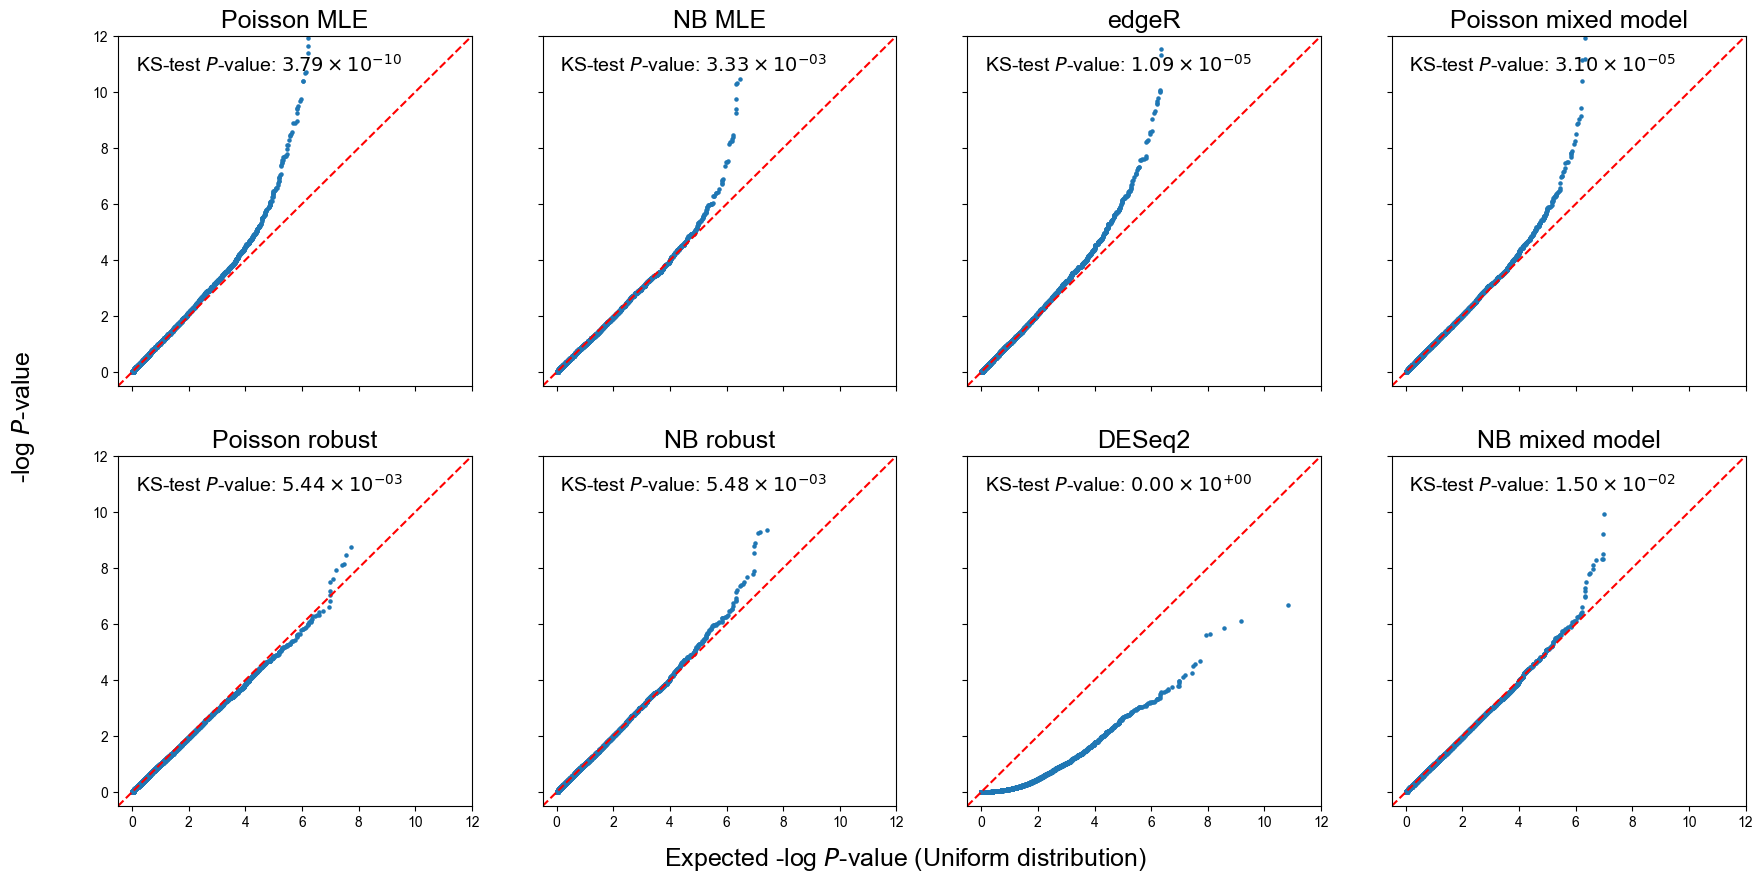

In [126]:
from decimal import Decimal
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(2, 4, figsize=(5*4+1,5*2), sharex=True, sharey=True)

p_unif = np.sort(-np.log(np.random.uniform(size=gene_p_pr.shape)))

# main scatters
pvals = [gene_p_pr, gene_p_nb, gene_p_edger, gene_p_pmm, gene_p_rpr, gene_p_ggp, gene_p_deseq2, gene_p_nbmm]
labels= ['Poisson MLE', 'NB MLE', 'edgeR', 'Poisson mixed model', 'Poisson robust', 'NB robust', 'DESeq2', 'NB mixed model']
for i, pval, label in zip(range(8),pvals,labels):
    row, col = int(i/4), i%4

    ax[row, col].scatter(p_unif, np.sort(-np.log(pval)), s=5)
    ax[row, col].plot([-0.5, 15], [-0.5,15], ls='--', c='red')
    ax[row, col].set_title(label, fontsize=18)
    ks_pval = stats.kstest(np.sort(pval), stats.uniform.cdf)[1]
    
    if np.isnan(pval).sum():
        pval[np.isnan(pval)] = 1
        ks_pval = stats.kstest(np.sort(pval), stats.uniform.cdf)[1]
        base = ('%.2E' % Decimal(ks_pval)).split('E')[0]
        exp = ('%.2E' % Decimal(ks_pval)).split('E')[1]
        ax[row,col].text(
            0.05, 0.9, r'KS-test $P$-value: $%s \times 10^{%s}$' % (base, exp),
            transform=ax[row,col].transAxes, 
            fontsize=14
        )
    elif np.isnan(ks_pval):
        ax[row,col].text(
            0.05, 0.9, r'KS-test $P$-value: <$2 \times 10^{-200}$',
            transform=ax[row,col].transAxes, 
            fontsize=14
        )
    else:
        base = ('%.2E' % Decimal(ks_pval)).split('E')[0]
        exp = ('%.2E' % Decimal(ks_pval)).split('E')[1]
        ax[row,col].text(
            0.05, 0.9, r'KS-test $P$-value: $%s \times 10^{%s}$' % (base, exp),
            transform=ax[row,col].transAxes, 
            fontsize=14
        )    

ax[0,0].set_xlim([-0.5, 12])
ax[0,0].set_ylim([-0.5, 12])    
fig.text(0.5, 0.05, r'Expected -log $P$-value (Uniform distribution)', fontsize=18, ha='center')
fig.text(0.08, 0.5, r'-log $P$-value', fontsize=18, rotation=90, ha='center', va='center')



plt.show()

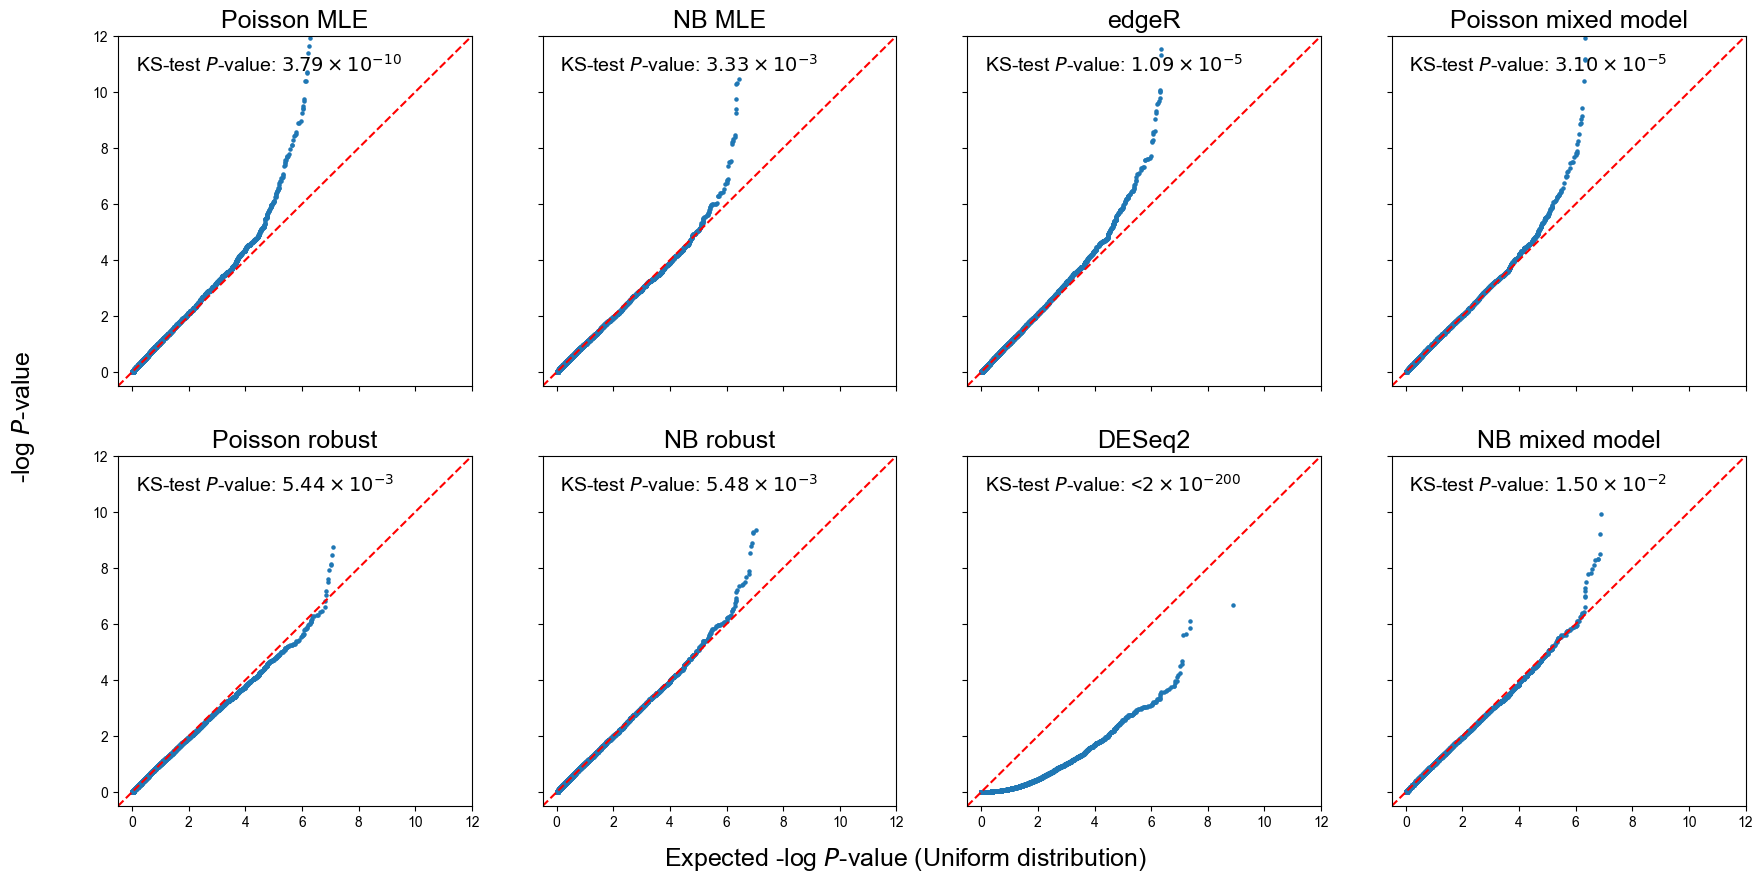

In [7]:
from decimal import Decimal
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(2, 4, figsize=(5*4+1,5*2), sharex=True, sharey=True)

p_unif = np.sort(-np.log(np.random.uniform(size=pvals[0].shape)))

# main scatters
#pvals = [gene_p_pr, gene_p_nb, gene_p_edger, gene_p_pmm, gene_p_rpr, gene_p_ggp, gene_p_deseq2, gene_p_nbmm]
labels= ['Poisson MLE', 'NB MLE', 'edgeR', 'Poisson mixed model', 'Poisson robust', 'NB robust', 'DESeq2', 'NB mixed model']
for i, pval, label in zip(range(8),pvals,labels):
    row, col = int(i/4), i%4

    ax[row, col].scatter(p_unif, np.sort(-np.log(pval)), s=5)
    ax[row, col].plot([-0.5, 15], [-0.5,15], ls='--', c='red')
    ax[row, col].set_title(label, fontsize=18)
    ks_pval = stats.kstest(np.sort(pval), stats.uniform.cdf)[1]
    
    if np.isnan(pval).sum():
        pval[np.isnan(pval)] = 1
        ks_pval = stats.kstest(np.sort(pval), stats.uniform.cdf)[1]
        base = ('%.2E' % Decimal(ks_pval)).split('E')[0]
        exp = ('%.2E' % Decimal(ks_pval)).split('E')[1]
        ax[row,col].text(
            0.05, 0.9, r'KS-test $P$-value: $%s \times 10^{%s}$' % (base, exp),
            transform=ax[row,col].transAxes, 
            fontsize=14
        )
    elif np.isnan(ks_pval) or ks_pval<1e-200:
        ax[row,col].text(
            0.05, 0.9, r'KS-test $P$-value: <$2 \times 10^{-200}$',
            transform=ax[row,col].transAxes, 
            fontsize=14
        )
    else:
        base = ('%.2E' % Decimal(ks_pval)).split('E')[0]
        exp = ('%.2E' % Decimal(ks_pval)).split('E')[1]
        if exp[1] == '0':
            exp = exp[0]+exp[2] 
        ax[row,col].text(
            0.05, 0.9, r'KS-test $P$-value: $%s \times 10^{%s}$' % (base, exp),
            transform=ax[row,col].transAxes, 
            fontsize=14
        )
    
    

ax[0,0].set_xlim([-0.5, 12])
ax[0,0].set_ylim([-0.5, 12])    
fig.text(0.5, 0.05, r'Expected -log $P$-value (Uniform distribution)', fontsize=18, ha='center')
fig.text(0.08, 0.5, r'-log $P$-value', fontsize=18, rotation=90, ha='center', va='center')



plt.show()

In [25]:
import pickle
 
## Save pickle
with open("pvals_yazar_5000.pickle","wb") as fw:
    pickle.dump(pvals, fw)


In [1]:
import pickle

## Load pickle
with open("pvals_yazar_5000.pickle","rb") as fr:
    pvals = pickle.load(fr)

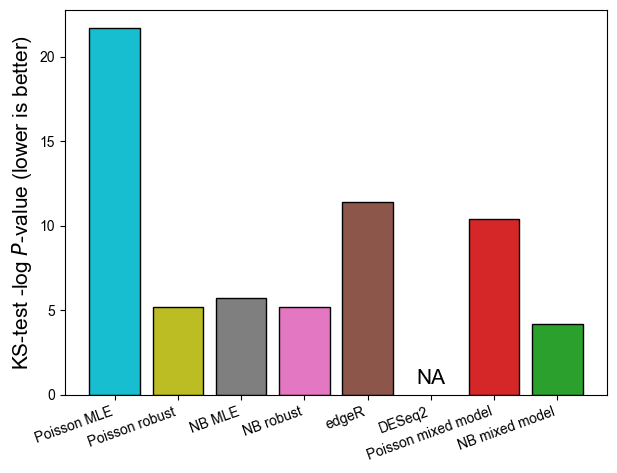

In [13]:
from decimal import Decimal
plt.rcParams['font.family'] = 'Arial'

import matplotlib

cmap = matplotlib.cm.get_cmap('tab10_r')


fig, ax = plt.subplots(figsize=(7,5))

#labels= ['Poisson MLE', 'NB MLE', 'edgeR', 'Poisson mixed model', 'Poisson robust', 'NB robust', 'DESeq2', 'NB mixed model']
labels = ['Poisson MLE', 'Poisson robust', 'NB MLE', 'NB robust', 'edgeR', 'DESeq2', 'Poisson mixed model', 'NB mixed model']
pvalss = [pvals[i] for i in [0,4,1,5,2,6,3,7]]
ks_pvals = []
for i, pval in enumerate(pvalss):
    ks_pval = stats.kstest(pval, stats.uniform.cdf)[1]
    ks_pvals.append(ks_pval)

ax.bar(
    labels, 
    -np.log(ks_pvals),
    color=cmap((range(len(pvals)))),
    edgecolor='black')

# axis legend
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha='right')
ax.set_ylabel('KS-test -log $\it{P}$-value (lower is better)', fontsize=15)

# DEseq2 legend
ax.text(5, 1, 'NA', ha='center', va='center', fontsize=15)


plt.show()

## Supplementary

## Pseudobulk robust NB

In [133]:
%%time
%%R -i matrix_pb_count -i matrix_pb_design -i subject_label -o gene_p_pb_ggp -o gene_beta_pb_ggp -o size_factor_pb

fit <- glmGamPoi::glm_gp(
    as.matrix(matrix_pb_count),
    matrix_pb_design,
    on_disk=FALSE
)
test <- glmGamPoi::test_de(fit, contrast=`Coef_2`)

gene_beta_pb_ggp <- summary(fit)$Beta[,2]
gene_p_pb_ggp <- test$pval
size_factor_pb <- fit$size_factors

CPU times: user 8min 16s, sys: 26.1 s, total: 8min 42s
Wall time: 1min 32s


## Pseudobulk MLE Poisson

In [76]:
%%time
gene_beta_pb_pr = np.zeros(matrix_count.shape[1])
gene_bse_pb_pr = np.zeros(matrix_count.shape[1])
gene_p_pb_pr = np.zeros(matrix_count.shape[1])

for gene_idx_int in range(matrix_count.shape[1]):
    mod = sm.GLM(
        endog=matrix_pb_count.T[:,gene_idx_int].toarray().ravel(), 
        exog=matrix_pb_design, 
        family=sm.families.Poisson(), 
        offset=np.log(size_factor_pb)
    )
    fit = mod.fit(tol=1e-10)
    gene_beta_pb_pr[gene_idx_int] = fit.params[1]
    gene_bse_pb_pr[gene_idx_int] = fit.bse[1]
    gene_p_pb_pr[gene_idx_int] = fit.pvalues[1]

CPU times: user 1min 19s, sys: 1.79 s, total: 1min 21s
Wall time: 1min 21s


## Pseudobulk MLE NB

In [77]:
%%time
gene_beta_pb_nb = np.zeros(matrix_count.shape[1])
gene_bse_pb_nb = np.zeros(matrix_count.shape[1])
gene_p_pb_nb = np.zeros(matrix_count.shape[1])

for gene_idx_int in range(matrix_count.shape[1]):
    mod = sm.GLM(
        endog=matrix_pb_count.T[:,gene_idx_int].toarray().ravel(), 
        exog=matrix_pb_design, 
        family=sm.families.NegativeBinomial(), 
        offset=np.log(size_factor_pb)
    )
    fit = mod.fit(tol=1e-10)
    gene_beta_pb_nb[gene_idx_int] = fit.params[1]
    gene_bse_pb_nb[gene_idx_int] = fit.bse[1]
    gene_p_pb_nb[gene_idx_int] = fit.pvalues[1]

CPU times: user 1min 17s, sys: 751 ms, total: 1min 17s
Wall time: 1min 17s


## Pseudobulk robust Poisson

In [92]:
%%time
gene_beta_pb_rpr = np.zeros(matrix_count.shape[1])
gene_bse_pb_rpr = np.zeros(matrix_count.shape[1])
gene_p_pb_rpr = np.zeros(matrix_count.shape[1])

for gene_idx_int in range(matrix_count.shape[1]):
    mod = sm.GLM(
        endog=matrix_pb_count.T[:,gene_idx_int].toarray().ravel(), 
        exog=matrix_pb_design, 
        family=sm.families.Poisson(), 
        offset=np.log(size_factor_pb) 
    )
    fit = mod.fit(cov_type='HC1', tol=1e-10)
    gene_beta_pb_rpr[gene_idx_int] = fit.params[1]
    gene_bse_pb_rpr[gene_idx_int] = fit.bse[1]
    gene_p_pb_rpr[gene_idx_int] = fit.pvalues[1]

CPU times: user 2min 18s, sys: 53.9 s, total: 3min 12s
Wall time: 1min 36s


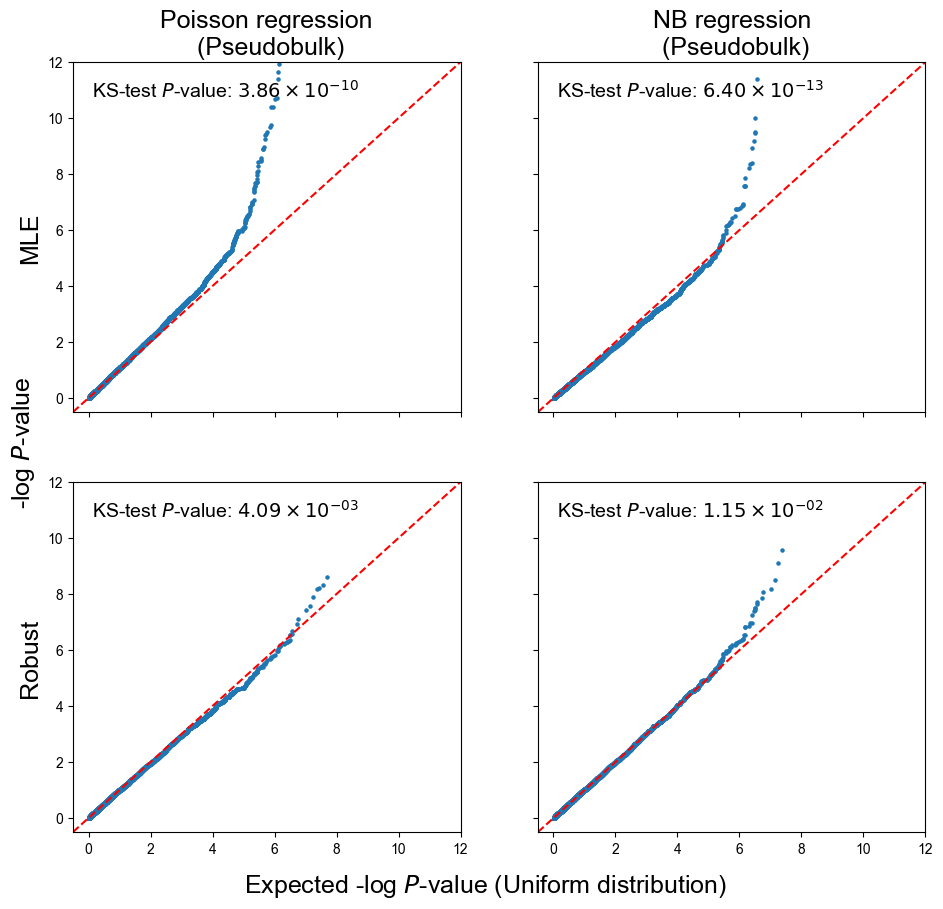

In [134]:
from decimal import Decimal
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(2, 2, figsize=(5*2+1,5*2), sharex=True, sharey=True)

p_unif = np.sort(-np.log(np.random.uniform(size=gene_p_pr.shape)))

# main scatters
pvals = [gene_p_pb_pr, gene_p_pb_nb, gene_p_pb_rpr, gene_p_pb_ggp]
labels= ['Poisson regression\n (Pseudobulk)', 'NB regression\n (Pseudobulk)', '', '']
for i, pval, label in zip(range(4),pvals,labels):
    row, col = int(i/2), i%2

    ax[row, col].scatter(p_unif, np.sort(-np.log(pval)), s=5)
    ax[row, col].plot([-0.5, 15], [-0.5,15], ls='--', c='red')
    ax[row, col].set_title(label, fontsize=18)
    ks_pval = stats.kstest(np.sort(pval), stats.uniform.cdf)[1]
    
    if np.isnan(pval).sum():
        pval[np.isnan(pval)] = 1
        ks_pval = stats.kstest(np.sort(pval), stats.uniform.cdf)[1]
        base = ('%.2E' % Decimal(ks_pval)).split('E')[0]
        exp = ('%.2E' % Decimal(ks_pval)).split('E')[1]
        ax[row,col].text(
            0.05, 0.9, r'KS-test $P$-value: $%s \times 10^{%s}$' % (base, exp),
            transform=ax[row,col].transAxes, 
            fontsize=14
        )
    elif np.isnan(ks_pval):
        ax[row,col].text(
            0.05, 0.9, r'KS-test $P$-value: <$2 \times 10^{-200}$',
            transform=ax[row,col].transAxes, 
            fontsize=14
        )
    else:
        base = ('%.2E' % Decimal(ks_pval)).split('E')[0]
        exp = ('%.2E' % Decimal(ks_pval)).split('E')[1]
        ax[row,col].text(
            0.05, 0.9, r'KS-test $P$-value: $%s \times 10^{%s}$' % (base, exp),
            transform=ax[row,col].transAxes, 
            fontsize=14
        )
        
    if col == 0:
        if row == 0:
            ax[row,col].set_ylabel('MLE', fontsize=18)
        else:
            ax[row,col].set_ylabel('Robust', fontsize=18)
    

ax[0,0].set_xlim([-0.5, 12])
ax[0,0].set_ylim([-0.5, 12])    
fig.text(0.5, 0.05, r'Expected -log $P$-value (Uniform distribution)', fontsize=18, ha='center')
fig.text(0.08, 0.5, r'-log $P$-value', fontsize=18, rotation=90, ha='center', va='center')



plt.show()

In [127]:
%%time
gene_beta_pb_cpr = np.zeros(matrix_count.shape[1])
gene_bse_pb_cpr = np.zeros(matrix_count.shape[1])
gene_p_pb_cpr = np.zeros(matrix_count.shape[1])

for gene_idx_int in range(matrix_count.shape[1]):
    mod = sm.GLM(
        endog=matrix_count[:,gene_idx_int].toarray().ravel(), 
        exog=matrix_design, 
        family=sm.families.Poisson(), 
        offset=np.log(cell_sizefactor)
    )
    fit = mod.fit(cov_type='cluster', tol=1e-10, cov_kwds={'groups':cell_subject})
    gene_beta_pb_cpr[gene_idx_int] = fit.params[1]
    gene_bse_pb_cpr[gene_idx_int] = fit.bse[1]
    gene_p_pb_cpr[gene_idx_int] = fit.pvalues[1]

CPU times: user 1h 38min 59s, sys: 3h 46min 52s, total: 5h 25min 52s
Wall time: 12min 44s


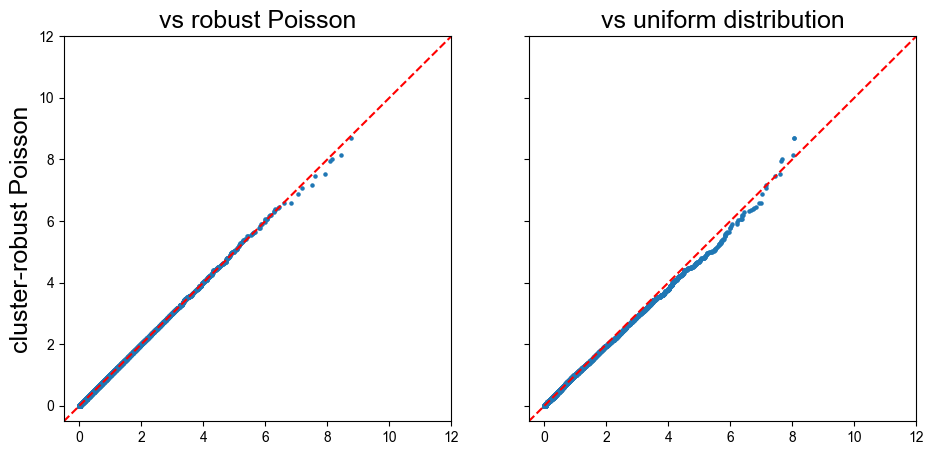

In [132]:
from decimal import Decimal
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(1, 2, figsize=(5*2+1,5*1), sharex=True, sharey=True)

p_unif = np.random.uniform(size=gene_p_pr.shape)

# main scatters
pvals = [gene_p_rpr, p_unif]
labels= ['vs robust Poisson', 'vs uniform distribution']
for i, pval, label in zip(range(4),pvals,labels):
    row, col = int(i/2), i%2

    ax[col].scatter(np.sort(-np.log(pval)), np.sort(-np.log(gene_p_pb_cpr)), s=5)
    ax[col].plot([-0.5, 15], [-0.5,15], ls='--', c='red')
    ax[col].set_title(label, fontsize=18) 

    if col == 0:
        if row == 0:
            ax[col].set_ylabel('cluster-robust Poisson', fontsize=18)
    

ax[0].set_xlim([-0.5, 12])
ax[0].set_ylim([-0.5, 12])    

plt.show()

## Fixest
%%time
%%R -i matrix_pb_count -i matrix_pb_design -i cell_sizefactor -i cell_subject -o gene_beta_pb_fe -o gene_p_pb_fe

data <- matrix_pb_count@x
row_indices <- matrix_pb_count@j # j,p both 0-base like base R
indptr <- matrix_pb_count@p

gene_beta_pb_fe <- rep(0, ncol(matrix_count))
gene_p_pb_fe <- rep(1, ncol(matrix_count))

for (gene_idx_int in 1:ncol(matrix_count)){
    # select gene from count matrix: manual indexing for speed
    y <- rep(0, ncol(matrix_pb_count))
    y[row_indices[(indptr[gene_idx_int]+1):indptr[gene_idx_int+1]]+1] <- data[(indptr[gene_idx_int]+1):indptr[gene_idx_int+1]]
    
    # design matrix for fixest
    df_matrix_design <- as.data.frame(matrix_pb_design)
    df <- cbind(y, df_matrix_design)
    
    # fixest fit
    fit <- fepois(y ~ V2, data=df, vcov='hetero', offset=log(size_factor_pb))
    
    gene_beta_pb_fe[gene_idx_int] <- coeftable(fit)[2,1]
    gene_p_pb_fe[gene_idx_int] <- coeftable(fit)[2,4]   
}